In [1]:
import numpy as np

gt = np.load("data/gt.npy")     # Texture,NormalMap,PointCloud
gt_texture = gt[0,:,:,:]
gt_normal = gt[1,:,:,:]
gt_pcd = gt[2,:,:,:]
print(gt_pcd.shape)

(1200, 1680, 3)


""

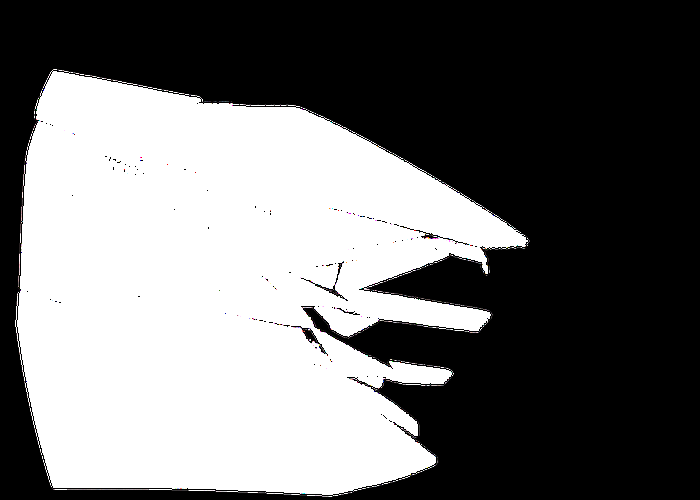

""

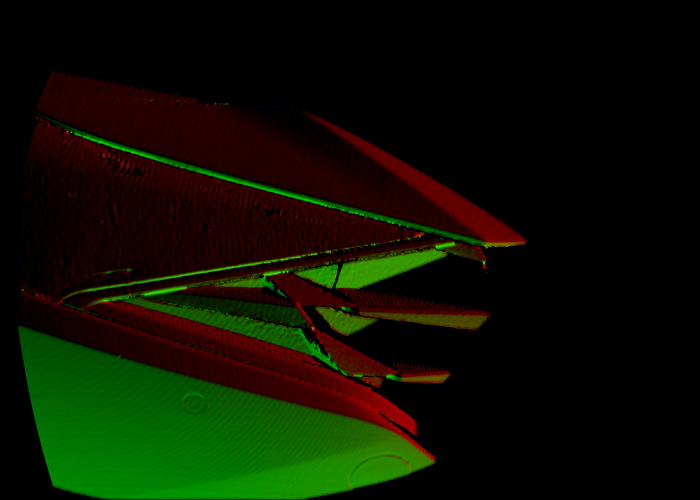

In [2]:
import mediapy as mp
mp.show_image(gt_texture, width = 700)
mp.show_image(gt_normal, width = 700)

In [3]:
import tqdm
gt_o3d = []

for i in tqdm.tqdm(range(gt_pcd.shape[0]), desc="Processing rows"):
    for j in range(gt_pcd.shape[1]):
        temp = gt_pcd[i,j,:]
        if np.sum(temp) != 0:
            gt_o3d.append(temp)

gt_o3d = np.array(gt_o3d)
print(gt_o3d.shape)

Processing rows: 100%|██████████| 1200/1200 [00:04<00:00, 251.92it/s]


(873662, 3)


In [4]:
import open3d as o3d

def custom_draw_geometry(pcd):
    vis = o3d.visualization.VisualizerWithKeyCallback()
    vis.create_window()
    vis.add_geometry(pcd)
    
    # Define callback function for ESC key
    def close_callback(vis):
        vis.destroy_window()
        return False
    
    # Register the callback function with key "Escape" (key value 256)
    vis.register_key_callback(256, close_callback)
    
    # Run the visualizer
    vis.run()
    vis.destroy_window()

# Create your point cloud
gt_pcd = o3d.geometry.PointCloud()
gt_pcd.points = o3d.utility.Vector3dVector(gt_o3d)

# Run the custom visualization
custom_draw_geometry(gt_pcd)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


2024-12-10 17:04:16.072 python[69756:4484726] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-10 17:04:16.072 python[69756:4484726] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [5]:
scan = np.load("data/scan.npy")
scan_pcd = scan[2,:,:,:]
print(scan_pcd.shape)

scan_o3d = []

for i in tqdm.tqdm(range(scan_pcd.shape[0]), desc="Processing rows"):
    for j in range(scan_pcd.shape[1]):
        temp = scan_pcd[i,j,:]
        if np.sum(temp) != 0:
            scan_o3d.append(temp)

scan_o3d = np.array(scan_o3d)
print(scan_o3d.shape)

(1200, 1680, 3)


Processing rows: 100%|██████████| 1200/1200 [00:04<00:00, 260.65it/s]


(619907, 3)


In [6]:
scan_pcd = o3d.geometry.PointCloud()
scan_pcd.points = o3d.utility.Vector3dVector(scan_o3d)

custom_draw_geometry(scan_pcd)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [7]:
target = gt_o3d
source = scan_o3d

In [8]:
from sklearn.neighbors import NearestNeighbors

def nearest_neighbor(sorce, target, n_neighbors=1):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(target)
    distances, indices = neigh.kneighbors(sorce, return_distance=True)
    return distances.ravel(), indices.ravel()

def pcd_transform(point_cloud,Tm):
    np_point_cloud = point_cloud.reshape((-1,3))
    num = np_point_cloud.shape[0]
    np_point_cloud = np.concatenate([ np_point_cloud,np.ones((num,1)) ],axis=-1)
    t_pcd = np.dot(Tm,np_point_cloud.T).T
    return t_pcd[:,:3]

def find_approximation_transform(sorce, target):
    
    A = target.reshape((-1,3))
    B = sorce.reshape((-1,3))

    # 평균점 구하기
    cp_A = np.mean(A,axis=0).reshape((1,3))
    cp_B = np.mean(B,axis=0).reshape((1,3))

    # centroid화   
    X = A-cp_A
    Y = B-cp_B
    
    # 공분산행렬 계산
    D = np.dot(Y.T,X)

    # 특이값분해
    U,S,V_T = np.linalg.svd(D)
    
    # 근사행렬 == 회전행렬 계산
    R = np.dot(V_T,U)

    # 평균점과 구한 회전행렬을 이용하여 이동벡터 계산
    t =  cp_A.T - np.dot(R,cp_B.T)
    
    # 4x4 Transform matrix로 반환
    Tm = np.eye(4)
    Tm[:3,:3] = R[:3,:3]
    Tm[:3,3] = t.T

    return Tm

def ICP(source, target, iteration = 10, threshold = 1e-7):
    # 초기 자세(Pose) 정의 
    Tm = np.eye(4)
    # 초기 오차
    Error = 0

    # 최종 변환 자세
    final_Tm = Tm.copy()

    # 만약 초기 자세를 알면 아래 코드를 활성화
    local_source = pcd_transform(source,Tm)

    # 반복적(Iterative) 계산
    for _ in range(iteration):
        # 가까운 매칭점 계산
        distances, indices=nearest_neighbor(local_source,target)
        
        # 포인트간 평균 거리 계산
        Error = distances.mean()
        
        # 포인트 평균 거리가 한계값보다 작다면 더 이상 찾지 않고 반환
        if(Error<threshold):
            break

        # 매칭점과 두 포인트클라우드를 이용하여 근사 변환행렬 계산
        Tm = find_approximation_transform(local_source,target[indices])

        
        # source 포인트클라우드 변환행렬(Tm)을 이용하여 변환
        local_source = pcd_transform(local_source, Tm)

        # 근사된 변환행렬 반복적으로 누적하여 정합된 변환 추정
        final_Tm = np.matmul(Tm,final_Tm)

    return Error,final_Tm

In [9]:
distances,indices=nearest_neighbor(source,target)
Tm = find_approximation_transform(source,target[indices])
source = pcd_transform(source,Tm)

In [10]:
import open3d as o3d

def visualize_point_clouds(point_cloud1, point_cloud2, 
                            window_width=1920, 
                            window_height=1080, 
                            point_size=1.0):
    """
    Visualize two point clouds with different colors using Open3D.
    
    Parameters:
    point_cloud1 (numpy.ndarray): First point cloud with shape (N, 3)
    point_cloud2 (numpy.ndarray): Second point cloud with shape (M, 3)
    window_width (int): Width of the visualization window
    window_height (int): Height of the visualization window
    point_size (float): Size of the points in the visualization
    """
    # Create Open3D point cloud objects
    pcd1 = o3d.geometry.PointCloud()
    pcd2 = o3d.geometry.PointCloud()
    
    # Set point cloud coordinates
    pcd1.points = o3d.utility.Vector3dVector(point_cloud1)
    pcd2.points = o3d.utility.Vector3dVector(point_cloud2)
    
    # Set different colors for each point cloud
    pcd1.paint_uniform_color([1, 0, 0])  # Red
    pcd2.paint_uniform_color([0, 1, 0])  # Green
    
    # Create visualizer with specified window size
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=window_width, height=window_height)
    
    # Add point clouds to visualizer
    vis.add_geometry(pcd1)
    vis.add_geometry(pcd2)
    
    # Set point cloud rendering properties
    render_option = vis.get_render_option()
    render_option.point_size = point_size  # Adjust point size
    
    # Optional: Adjust background color
    # render_option.background_color = np.asarray([0.1, 0.1, 0.1])
    
    # Set up the coordinate frame
    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])
    vis.add_geometry(coord_frame)
    
    # Update the view and render
    vis.update_geometry(pcd1)
    vis.update_geometry(pcd2)
    vis.poll_events()
    vis.update_renderer()
    
    # Run the visualizer
    vis.run()
    
    # Optional: Close the window
    vis.destroy_window()

visualize_point_clouds(source, target) # Source: Red, Target: Green

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
